In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np 
from glob import glob
from utils.geotif_io import readTiff
import rasterio as rio
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.colors import LightSource
from matplotlib.colors import LinearSegmentedColormap
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import warnings
warnings.filterwarnings("ignore")


In [2]:
dir_dif_map = 'data/aster-stereo/tiles-dif-map'
paths_dif_map = glob(dir_dif_map + '/tile_??_??.tif')
path_result_glacier = 'data/ele-change-result/ele_change_glaciers.pkl'
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
path_dem = 'data/dem-data/srtm-c/SRTMGL3_900m.tif'
path_result_glacier_dif_map = 'data/ele-change-result/ele_change_glaciers_dif_map.pkl'
years = [str(year) for year in range(1990,2030)]


In [3]:
### 1. read in dem
dem, dem_info = readTiff(path_dem)
### 2. read in rates of glaciers
result_glaciers = pd.read_pickle(path_result_glacier)
result_glaciers = gpd.GeoDataFrame(result_glaciers, geometry='geometry')
result_glaciers_sorted = result_glaciers.sort_values(by='gla_area', ascending=False)



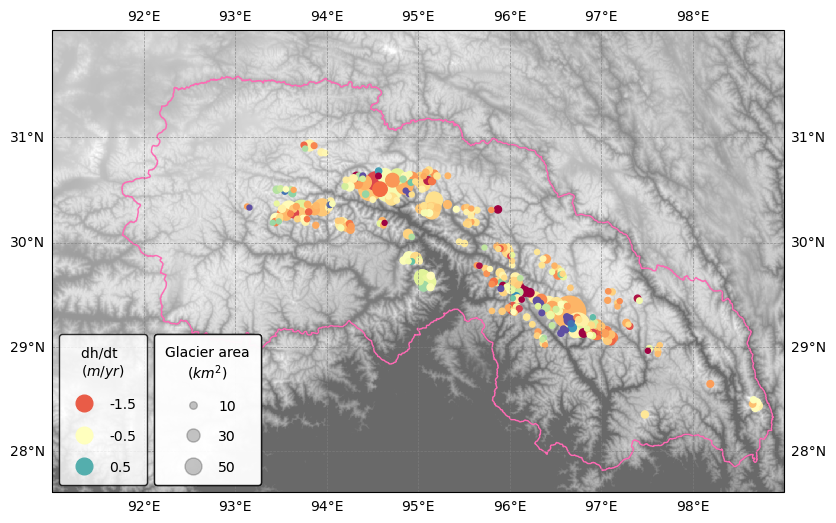

In [4]:
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
cmap_dhdt = plt.cm.get_cmap('Reds').reversed()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([91, 99, 27.6, 32])
ax_dem = ax.imshow(dem, extent=dem_info['geoextent'], 
                                vmin=2500, vmax=6000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=0)   ## cmap:PRGn

## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='HotPink', linewidth=1, facecolor='none')

ax.add_feature(shp_fea, zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.8, zorder=1, color='grey', linestyle='--')

size_scale = 3
scatter = ax.scatter(
    x = result_glaciers_sorted['geometry'].centroid.x,
    y = result_glaciers_sorted['geometry'].centroid.y,
    s = result_glaciers_sorted['gla_area']*size_scale,
    c = result_glaciers_sorted['rate'],
    cmap = 'Spectral',
    # marker='^',
    alpha=1, 
    linewidth=1,
    vmin=-2,
    vmax=1,
    transform=ccrs.PlateCarree(),
    )

# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements(prop="colors", num=[-1.5,-0.5,0.5], fmt="{x:.1f}")
legend_color = ax.legend(handles, labels, loc="lower left", title="dh/dt \n($m/yr$)",\
                        facecolor='white', edgecolor='black', borderpad=0.8, labelspacing=1.25, markerscale=2)

# produce a legend with a cross-section of sizes from the scatter
handles_, labels_ = scatter.legend_elements(prop="sizes", \
                            num=[10*size_scale, 30*size_scale, 50*size_scale], alpha=0.2)
legend_size = ax.legend(handles_, [10, 30, 50], loc="lower left", title="Glacier area\n     (${km^2}$)", \
                            edgecolor='black', borderpad = 0.8, labelspacing=1.2, bbox_to_anchor=(0.13, 0.))
ax.add_artist(legend_color)
ax.add_artist(legend_size)


,rgi_id,ele_change,ele_change_fitting,rate,gla_area,dif_map,geometry,srtm_dem_masked
0,RGI60-13.00643,"[nan, nan, 1.3920956, 5.70497, nan, -5.4427314...","[6.804080363527813, 5.605532651339677, 4.40698...",-1.198548,28.533,"[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...","POLYGON ((94.97412 30.60416, 94.97372 30.60385...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,RGI60-13.00761,"[nan, nan, -0.84014434, -7.9066153, nan, -7.36...","[-0.3962745164217605, -0.8097009468614413, -1....",-0.413426,36.251,"[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...","POLYGON ((94.57537 30.65285, 94.57536 30.65286...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,RGI60-13.00763,"[nan, nan, nan, nan, nan, -3.8030918, -8.22740...","[14.077281169866385, 12.049899113739965, 10.02...",-2.027382,5.385,"[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...","POLYGON ((94.57356 30.64344, 94.57359 30.64346...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,RGI60-13.00777,"[nan, nan, nan, nan, nan, -5.682965, -4.779912...","[-8.416003455946306, -7.425009404880572, -6.43...",0.990994,5.293,"[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...","POLYGON ((94.39529 30.63960, 94.39546 30.63984...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,RGI60-13.00788,"[nan, nan, nan, nan, nan, 3.140373, 8.27838, n...","[10.858147635667219, 9.788267074882887, 8.7183...",-1.069881,34.120,"[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...","POLYGON ((94.43347 30.58483, 94.43378 30.58471...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


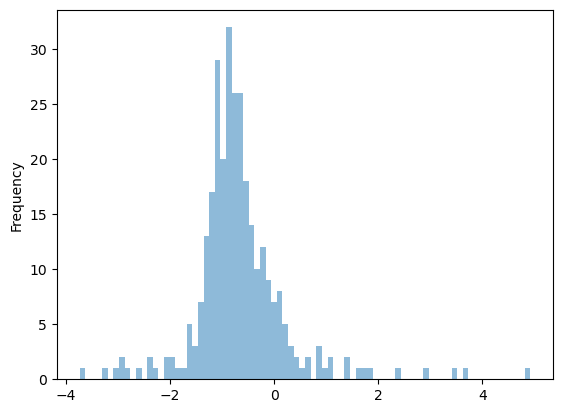

In [5]:
result_glaciers['rate'].plot.hist(alpha=0.5, bins=80)
result_glaciers.head()

## **Glaciers with different glacier melting rate.**

In [6]:
ids_rate_larger_0 = np.where(result_glaciers['rate']>0)[0]
ids_rate_neg1_0 = np.where((result_glaciers['rate']>-1) & (result_glaciers['rate']<0))[0]
ids_rate_smaller_neg1 = np.where(result_glaciers['rate']<-1)[0]
result_glaciers_larger_0 = result_glaciers.iloc[ids_rate_larger_0]
result_glaciers_neg1_0 = result_glaciers.iloc[ids_rate_neg1_0]
result_glaciers_smaller_neg1 = result_glaciers.iloc[ids_rate_smaller_neg1]


In [7]:
### The selected glaciers corresponding to different condition
### i_gla=22: 7, 11, 21; 
### i_gla=36: 2,8,17; 
### i_gla=78: 1, 8, 22
### i_gla=86: 1, 8, 22
## i_gla=64: 6, 12, 17
## i_gla=71: 6, 10, 17


Text(0.5, 1.0, 'glacier melting rate > 0')

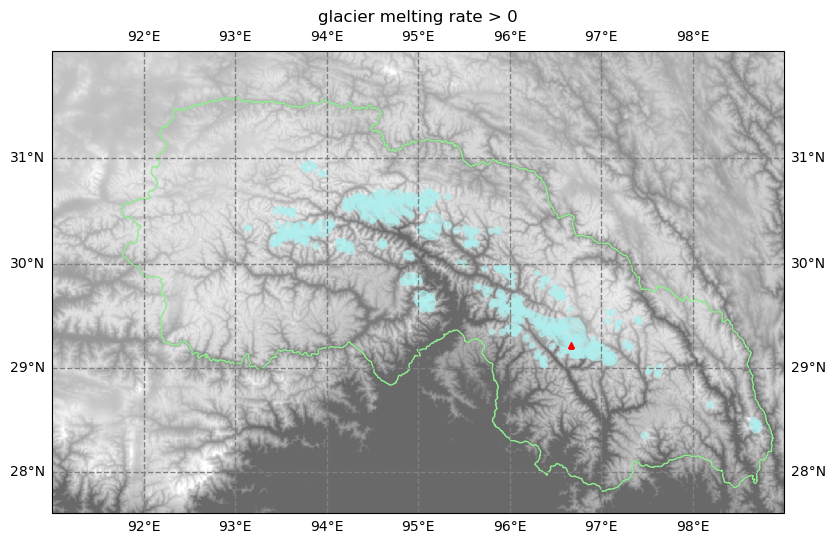

In [8]:
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
cmap_dhdt = plt.cm.get_cmap('Reds').reversed()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([91, 99, 27.6, 32])
ax_dem = ax.imshow(dem, extent=dem_info['geoextent'], 
                                vmin=2500, vmax=6000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=0)   ## cmap:PRGn

## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='lightgreen', linewidth=1, facecolor='none')

ax.add_feature(shp_fea, zorder=0)
ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='grey', linestyle='--')

size_scale = 3

scatter_all = ax.scatter(
    x = result_glaciers_sorted['geometry'].centroid.x,
    y = result_glaciers_sorted['geometry'].centroid.y,
    s = result_glaciers_sorted['gla_area']*size_scale,
    c = 'PaleTurquoise',
    # marker='^',
    alpha=0.6, 
    linewidth=1,
    transform=ccrs.PlateCarree(),
    )

# scatter_larger_0 = ax.scatter(
#     x = result_glaciers_larger_0['geometry'].centroid.x,
#     y = result_glaciers_larger_0['geometry'].centroid.y,
#     s = result_glaciers_larger_0['gla_area']*size_scale,
#     c = 'red',
#     marker='^',
#     alpha=1, 
#     linewidth=1,
#     transform=ccrs.PlateCarree(),
#     )


# scatter_neg1_0 = ax.scatter(
#     x = result_glaciers_neg1_0['geometry'].centroid.x,
#     y = result_glaciers_neg1_0['geometry'].centroid.y,
#     s = result_glaciers_neg1_0['gla_area']*size_scale,
#     c = 'Violet',
#     marker='^',
#     alpha=1, 
#     linewidth=1,
#     transform=ccrs.PlateCarree(),
#     )

# scatter_smaller_neg1 = ax.scatter(
#     x = result_glaciers_smaller_neg1['geometry'].centroid.x,
#     y = result_glaciers_smaller_neg1['geometry'].centroid.y,
#     s = result_glaciers_smaller_neg1['gla_area']*size_scale,
#     c = 'Orange',
#     marker='^',
#     alpha=1, 
#     linewidth=1,
#     transform=ccrs.PlateCarree(),
#     )

scatter = ax.scatter(
    x = result_glaciers_larger_0['geometry'].iloc[[36]].centroid.x,
    y = result_glaciers_larger_0['geometry'].iloc[[36]].centroid.y,
    s = result_glaciers_larger_0['gla_area'].iloc[[36]]*size_scale,
    c = 'red',
    marker='^',
    alpha=1, 
    linewidth=1,
    transform=ccrs.PlateCarree(),
    )

ax.set_title('glacier melting rate > 0')

# # produce a legend with a cross-section of sizes from the scatter
# handles_, labels_ = scatter.legend_elements(prop="sizes", \
#                             num=[10*size_scale, 30*size_scale, 50*size_scale], alpha=0.2)
# legend_size = ax.legend(handles_, [10, 30, 50], loc="lower left", title="Glacier area\n     (${km^2}$)", \
#                             edgecolor='black', borderpad = 0.8, labelspacing=1.2, bbox_to_anchor=(0.01, 0.))

# ax.add_artist(legend_size)



### **1. The glaciers with the melting rate larger than 0**

Text(0, 0.5, 'Elevation change')

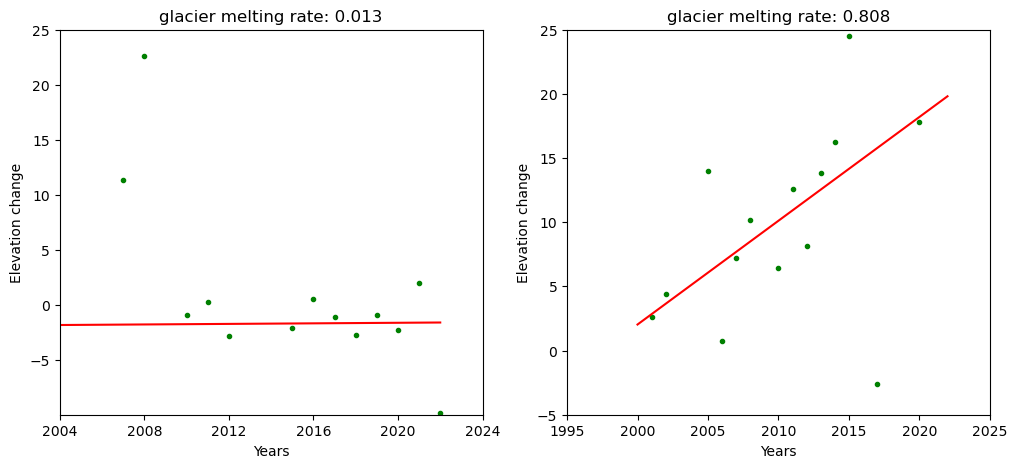

In [9]:
### i_gla = 22: 7, 11, 21; 
### i_gla = 36: 2, 8, 17; 
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(result_glaciers_larger_0['ele_change'].iloc[22],'.g')
ax[0].plot(result_glaciers_larger_0['ele_change_fitting'].iloc[22],'-r')
ax[0].set_ylim(-10, 10); ax[0].set_xlim(4, 24)
ax[0].set_title('glacier melting rate: %.3f'%result_glaciers_larger_0['rate'].iloc[22])
ax[0].set_xticks([4,8,12,16,20,24], [years[14], years[18], years[22], years[26], years[30], years[34]]); 
ax[0].set_yticks([-10,-6,-2,2,6,10])
ax[0].set_xlabel('Years'); ax[0].set_ylabel('Elevation change')

ax[1].plot(result_glaciers_larger_0['ele_change'].iloc[36],'.g')
ax[1].plot(result_glaciers_larger_0['ele_change_fitting'].iloc[36],'-r')
ax[1].set_ylim(-5, 25); ax[1].set_xlim(-5, 25)
ax[1].set_title('glacier melting rate: %.3f'%result_glaciers_larger_0['rate'].iloc[36])
ax[1].set_xticks(np.arange(-5,26,5), [years[i+10] for i in np.arange(-5,26,5)]); ax[0].set_yticks(np.arange(-5,26,5))
ax[1].set_xlabel('Years'); ax[1].set_ylabel('Elevation change')


In [ ]:
### crop the srtm dem of glaicer region.
# path_in = 'data/dem-data/srtm-c/SRTMGL1_E.tif'
# path_out = 'data/dem-data/srtm-c/individual_glaciers_analysis/rapid_melt_gla_1.tif'
# extent_sub = '96.37, 29.036, 96.408, 29.000'
# !gdal_translate -projwin $extent_sub -co COMPRESS=LZW $path_in $path_out

def dem_hillshape(path_dem, azdeg=0, altdeg=45):
  ls = LightSource(azdeg, altdeg)
  dem_gla, dem_gla_info = readTiff(path_dem)
  dx, dy = dem_gla_info['geotrans'][1], dem_gla_info['geotrans'][5]
  dy = 111200 * dy
  dx = 111200 * dx * np.cos(np.radians(dem_gla_info['geotrans'][3]))
  dem_shade_gla = ls.hillshade(dem_gla, vert_exag=0.8, dx=dx, dy=dy)
  return dem_shade_gla, dem_gla_info['geoextent'] 


In [55]:
path_dem_gla_1 = 'data/dem-data/srtm-c/individual_glaciers_analysis/accumulate_gla_1.tif'
path_dem_gla_2 = 'data/dem-data/srtm-c/individual_glaciers_analysis/accumulate_gla_2.tif'
dem_hillshade_1, dem_hillshade_1_extent = dem_hillshape(path_dem=path_dem_gla_1)
dem_hillshade_2, dem_hillshade_2_extent = dem_hillshape(path_dem=path_dem_gla_2)


In [59]:
dem_hillshade_1

array([[0.23408384, 0.37235147, 0.23346687, ..., 0.7706225 , 0.73051112,
        0.70159004],
       [0.37122493, 0.43413772, 0.4433578 , ..., 0.73051112, 0.69408899,
        0.67825396],
       [0.61373615, 0.51015907, 0.70222281, ..., 0.65152624, 0.64292237,
        0.64241208],
       ...,
       [0.60832935, 0.49077793, 0.57789324, ..., 0.95127334, 0.96857363,
        0.96327602],
       [0.69311779, 0.53595215, 0.48357405, ..., 0.97611395, 0.98291212,
        0.99003736],
       [0.71318023, 0.6370804 , 0.56562568, ..., 0.96437347, 0.99059784,
        0.99579942]])

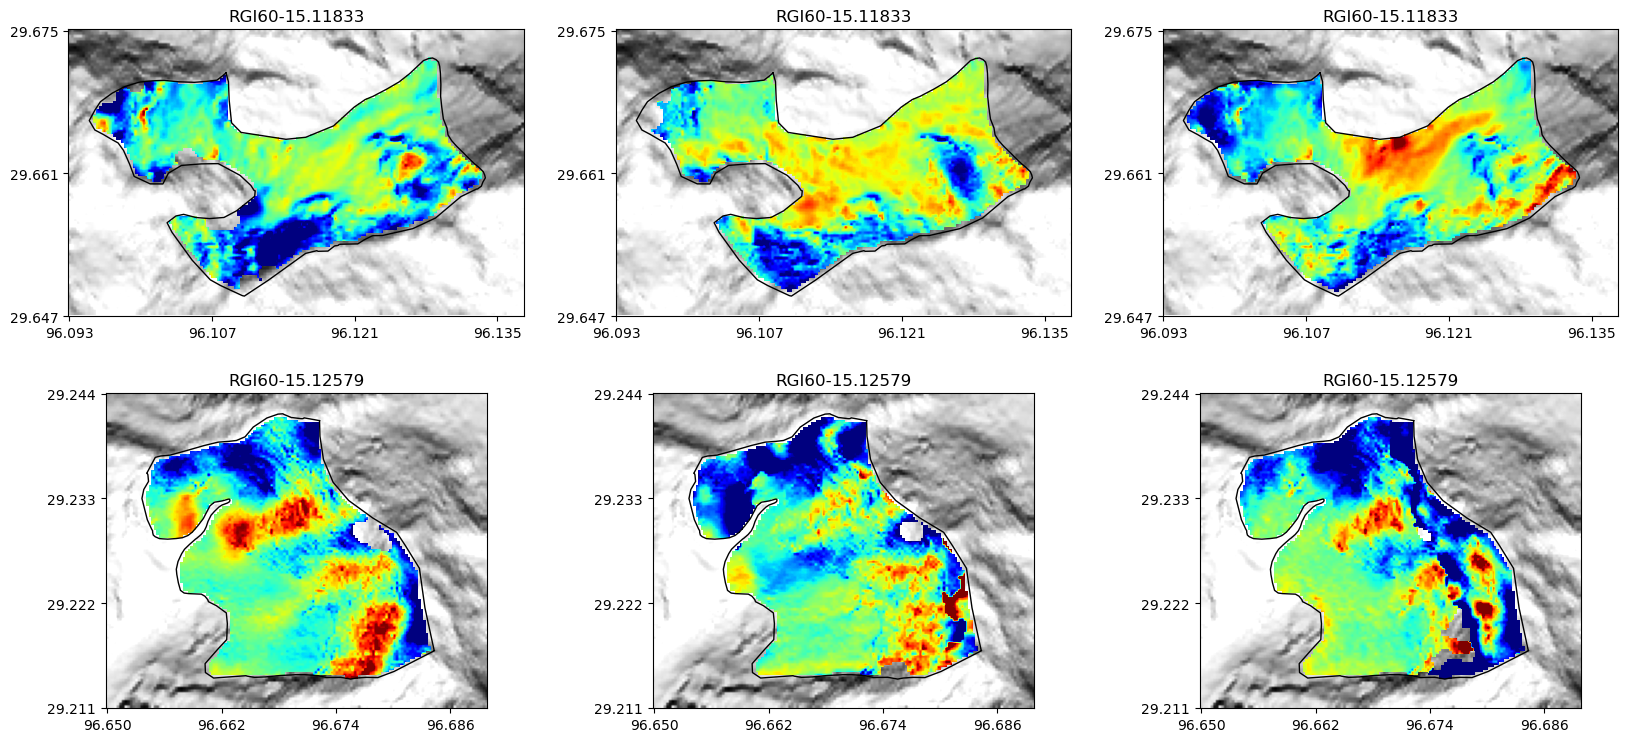

In [65]:
# result_glaciers_larger_0.head()
dif_map_1 = result_glaciers_larger_0['dif_map'].iloc[22]
bound_1 = result_glaciers_larger_0.iloc[22]['geometry'].bounds
extent_1 = [bound_1[0], bound_1[2], bound_1[1], bound_1[3]]
x_1, y_1 = result_glaciers_larger_0.iloc[22]['geometry'].exterior.xy

dif_map_2 = result_glaciers_larger_0.iloc[36]['dif_map']
bound_2 = result_glaciers_larger_0.iloc[36]['geometry'].bounds
extent_2 = [bound_2[0], bound_2[2], bound_2[1], bound_2[3]]
x_2, y_2 = result_glaciers_larger_0.iloc[36]['geometry'].exterior.xy

fig, ax = plt.subplots(2,3,figsize=(20,9))

for i in range(3):
  ax[0][i].imshow(dem_hillshade_1, extent=dem_hillshade_1_extent, vmin=0, vmax=0.9, cmap='gray')
ax[0][0].imshow(dif_map_1[7], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
ax[0][1].imshow(dif_map_1[11], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
ax[0][2].imshow(dif_map_1[21], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[0][i].plot(x_1, y_1, 'black', linewidth=1)
  ax[0][i].set_title(result_glaciers_larger_0['rgi_id'].iloc[22])
  ax[0][i].set_xticks(np.arange(96.093,96.1378,0.014)); ax[0][i].set_yticks(np.arange(29.647,29.6755,0.014))

for i in range(3):
  ax[1][i].imshow(dem_hillshade_2, extent=dem_hillshade_2_extent, vmin=0, vmax=0.9, cmap='gray')
ax[1][0].imshow(dif_map_2[2], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][1].imshow(dif_map_2[8], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][2].imshow(dif_map_2[13], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[1][i].plot(x_2, y_2, 'black', linewidth=1)
  ax[1][i].set_title(result_glaciers_larger_0['rgi_id'].iloc[36])
  ax[1][i].set_xticks(np.arange(96.65,96.69,0.012)); ax[1][i].set_yticks(np.arange(29.211,29.246,0.011))



### **2. The glaciers with the melting rate in the range of -1~0**


Text(0, 0.5, 'Elevation change')

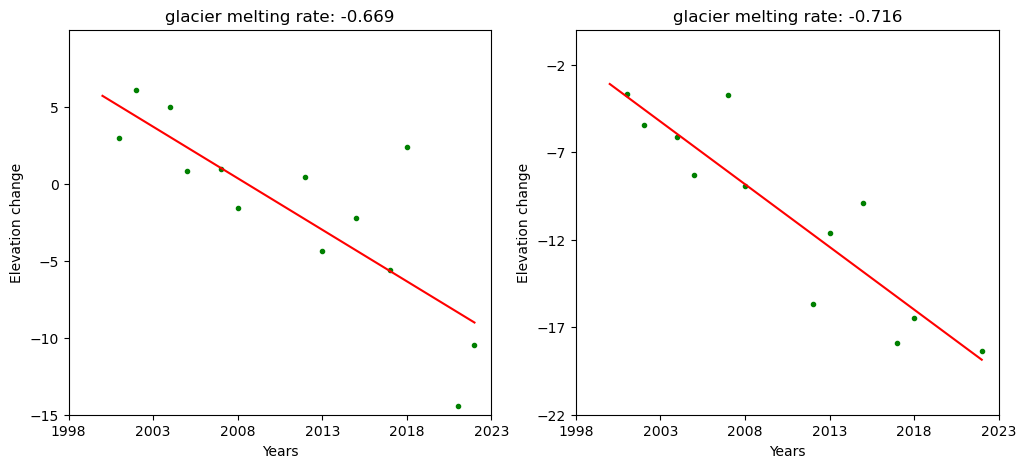

In [11]:
### i_gla=78; 1, 8, 22
### i_gla=86; 1, 8, 22
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(result_glaciers_neg1_0['ele_change'].iloc[78],'.g')
ax[0].plot(result_glaciers_neg1_0['ele_change_fitting'].iloc[78],'-r')
ax[0].set_ylim(-15, 10); ax[0].set_xlim(-2, 23)
ax[0].set_title('glacier melting rate: %.3f'%result_glaciers_neg1_0['rate'].iloc[78])
ax[0].set_xticks(np.arange(-2,24,5), [years[i+10] for i in np.arange(-2,24,5)]); 
ax[0].set_yticks(np.arange(-15,10,5))
ax[0].set_xlabel('Years'); ax[0].set_ylabel('Elevation change')

ax[1].plot(result_glaciers_neg1_0['ele_change'].iloc[86],'.g')
ax[1].plot(result_glaciers_neg1_0['ele_change_fitting'].iloc[86],'-r')
ax[1].set_xlim(-2, 20);ax[1].set_ylim(-22, 0)
ax[1].set_title('glacier melting rate: %.3f'%result_glaciers_neg1_0['rate'].iloc[86])
ax[1].set_xticks(np.arange(-2,24,5), [years[i+10] for i in np.arange(-2,24,5)]); 
ax[1].set_yticks(np.arange(-22,1,5))
ax[1].set_xlabel('Years'); ax[1].set_ylabel('Elevation change')


In [67]:
path_dem_gla_1 = 'data/dem-data/srtm-c/individual_glaciers_analysis/moderate_melt_gla_1.tif'
path_dem_gla_2 = 'data/dem-data/srtm-c/individual_glaciers_analysis/moderate_melt_gla_2.tif'
dem_hillshade_1, dem_hillshade_1_extent = dem_hillshape(path_dem=path_dem_gla_1)
dem_hillshade_2, dem_hillshade_2_extent = dem_hillshape(path_dem=path_dem_gla_2)


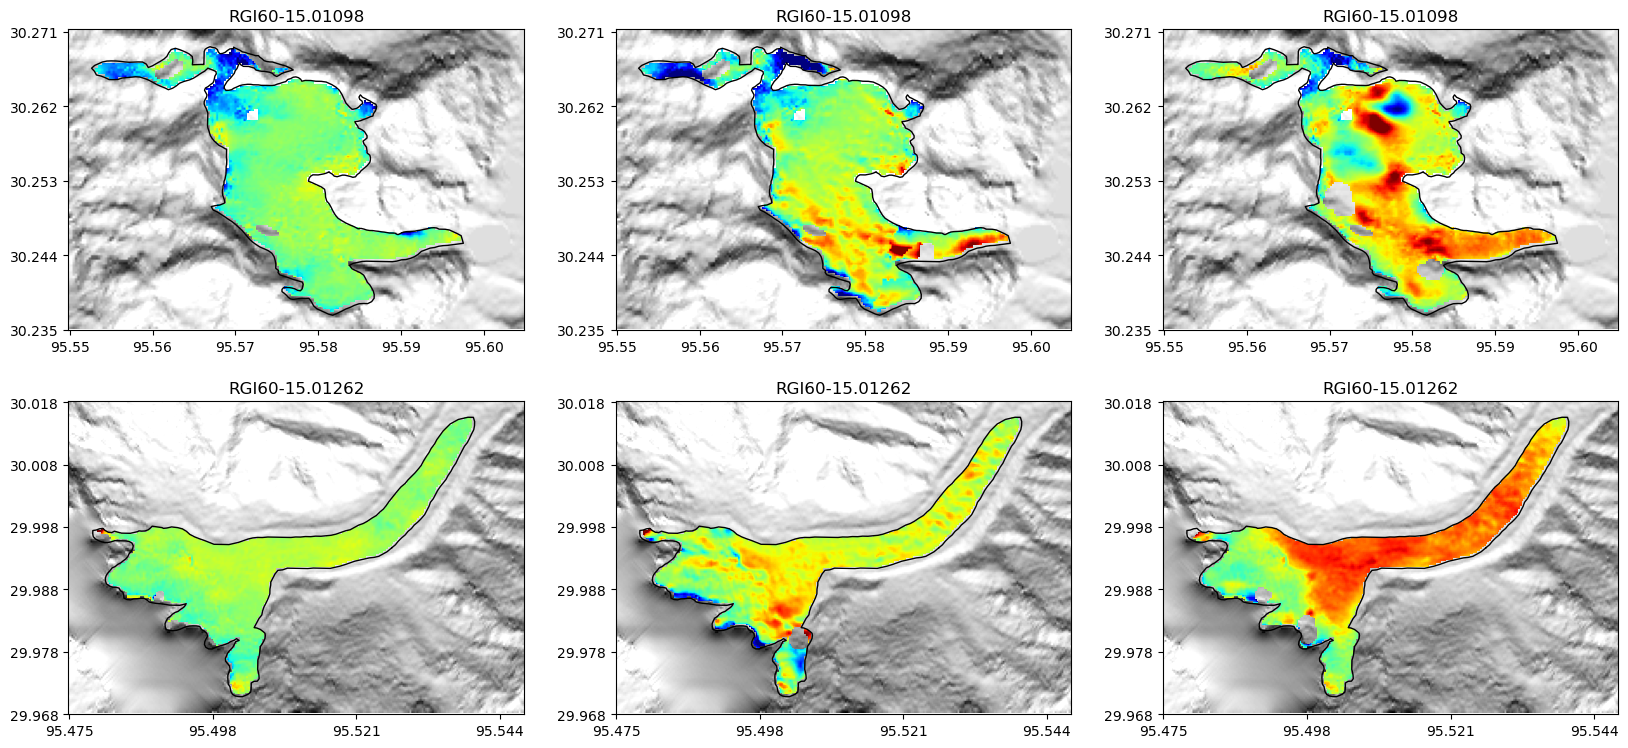

In [68]:
# result_glaciers_larger_0.head()
dif_map_1 = result_glaciers_neg1_0['dif_map'].iloc[78]
bound_1 = result_glaciers_neg1_0.iloc[78]['geometry'].bounds
extent_1 = [bound_1[0], bound_1[2], bound_1[1], bound_1[3]]
x_1, y_1 = result_glaciers_neg1_0.iloc[78]['geometry'].exterior.xy

dif_map_2 = result_glaciers_neg1_0.iloc[86]['dif_map']
bound_2 = result_glaciers_neg1_0.iloc[86]['geometry'].bounds
extent_2 = [bound_2[0], bound_2[2], bound_2[1], bound_2[3]]
x_2, y_2 = result_glaciers_neg1_0.iloc[86]['geometry'].exterior.xy

fig, ax = plt.subplots(2,3,figsize=(20,9))
### glacier 1
for i in range(3):
  ax[0][i].imshow(dem_hillshade_1, extent=dem_hillshade_1_extent, vmin=0, vmax=0.9, cmap='gray')
ax[0][0].imshow(dif_map_1[1], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
ax[0][1].imshow(dif_map_1[8], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
ax[0][2].imshow(dif_map_1[22], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[0][i].plot(x_1, y_1, 'black', linewidth=1)
  ax[0][i].set_title(result_glaciers_neg1_0['rgi_id'].iloc[78])
  ax[0][i].set_xticks(np.arange(95.55,95.605,0.01)); ax[0][i].set_yticks(np.arange(30.235,30.272,0.009))
### glacier 2
for i in range(3):
  ax[1][i].imshow(dem_hillshade_2, extent=dem_hillshade_2_extent, vmin=0, vmax=0.9, cmap='gray')
ax[1][0].imshow(dif_map_2[1], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][1].imshow(dif_map_2[8], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][2].imshow(dif_map_2[22], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[1][i].plot(x_2, y_2, 'black', linewidth=1)
  ax[1][i].set_title(result_glaciers_neg1_0['rgi_id'].iloc[86])
  ax[1][i].set_xticks(np.arange(95.475, 95.548, 0.023)); ax[1][i].set_yticks(np.arange(29.968, 30.023, 0.01))


### **3. The glaciers with the melting rate smaller than -1**

Text(0, 0.5, 'Elevation change')

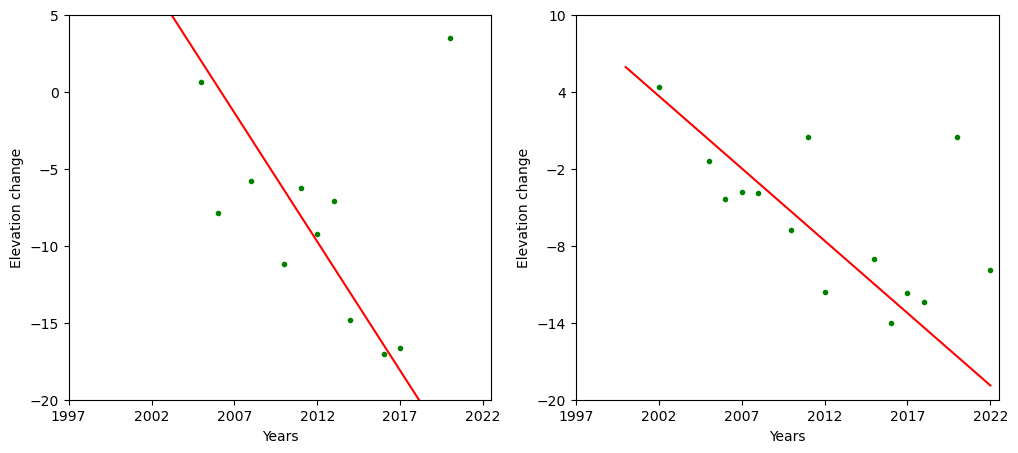

In [13]:
### i_gla = 64  ## 6, 12, 17
### i_gla = 71  ## 6, 10, 17
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(result_glaciers_smaller_neg1['ele_change'].iloc[64],'.g')
ax[0].plot(result_glaciers_smaller_neg1['ele_change_fitting'].iloc[64],'-r')
# ax[0].set_title('glacier melting rate: %.3f'%result_glaciers_smaller_neg1['rate'].iloc[64])
ax[0].set_xlim(-2.5,22.5); ax[0].set_ylim(-20, 5)
ax[0].set_xticks(np.arange(-3,23,5), [years[i+10] for i in np.arange(-3,23,5)]); 
ax[0].set_yticks(np.arange(-20,6,5))
ax[0].set_xlabel('Years'); ax[0].set_ylabel('Elevation change')

ax[1].plot(result_glaciers_smaller_neg1['ele_change'].iloc[71],'.g')
ax[1].plot(result_glaciers_smaller_neg1['ele_change_fitting'].iloc[71],'-r')
ax[1].set_xlim(-2.5,22.5); ax[1].set_ylim(-20, 10)
# ax[1].set_title('glacier melting rate: %.3f'%result_glaciers_smaller_neg1['rate'].iloc[71])
ax[1].set_xticks(np.arange(-3,23,5), [years[i+10] for i in np.arange(-3,23,5)]); 
ax[1].set_yticks(np.arange(-20,11,6))
ax[1].set_xlabel('Years'); ax[1].set_ylabel('Elevation change')



In [69]:
path_dem_gla_1 = 'data/dem-data/srtm-c/individual_glaciers_analysis/rapid_melt_gla_1.tif'
path_dem_gla_2 = 'data/dem-data/srtm-c/individual_glaciers_analysis/rapid_melt_gla_2.tif'
dem_hillshade_1, dem_hillshade_1_extent = dem_hillshape(path_dem=path_dem_gla_1)
dem_hillshade_2, dem_hillshade_2_extent = dem_hillshape(path_dem=path_dem_gla_2)


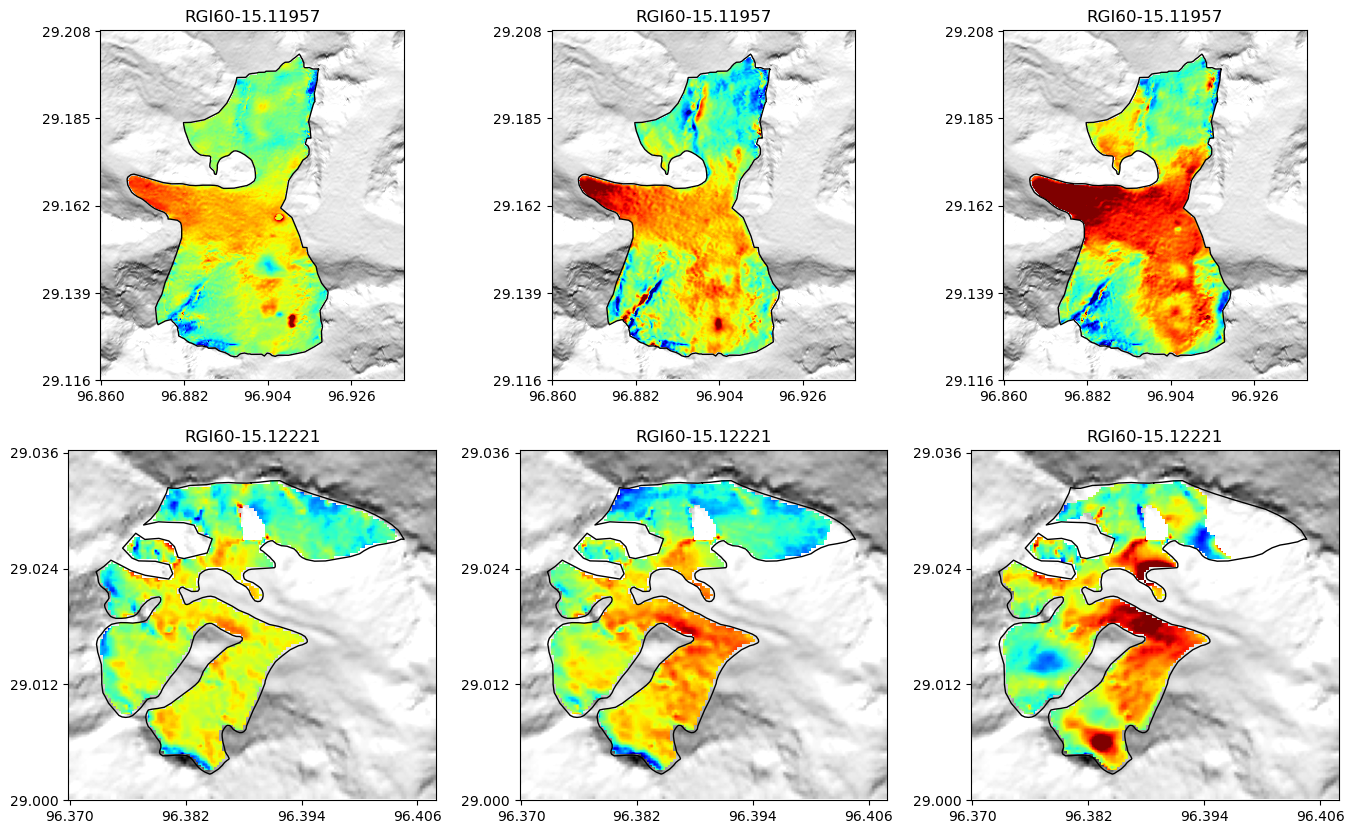

In [70]:
# result_glaciers_larger_0.head()
dif_map_1 = result_glaciers_smaller_neg1['dif_map'].iloc[64]
bound_1 = result_glaciers_smaller_neg1.iloc[64]['geometry'].bounds
extent_1 = [bound_1[0], bound_1[2], bound_1[1], bound_1[3]]
x_1, y_1 = result_glaciers_smaller_neg1.iloc[64]['geometry'].exterior.xy

dif_map_2 = result_glaciers_smaller_neg1.iloc[71]['dif_map']
bound_2 = result_glaciers_smaller_neg1.iloc[71]['geometry'].bounds
extent_2 = [bound_2[0], bound_2[2], bound_2[1], bound_2[3]]
x_2, y_2 = result_glaciers_smaller_neg1.iloc[71]['geometry'].exterior.xy

fig, ax = plt.subplots(2,3,figsize=(16.5, 10))
### glacier 1
for i in range(3):
  ax[0][i].imshow(dem_hillshade_1, extent=dem_hillshade_1_extent, vmin=0, vmax=0.9, cmap='gray')
ax[0][0].imshow(dif_map_1[6], vmax=50, vmin=-50, extent=extent_1, cmap=plt.cm.get_cmap('jet').reversed())
ax[0][1].imshow(dif_map_1[12], vmax=50, vmin=-50, extent=extent_1,cmap=plt.cm.get_cmap('jet').reversed())
ax[0][2].imshow(dif_map_1[17], vmax=50, vmin=-50, extent=extent_1,cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[0][i].plot(x_1, y_1, 'black', linewidth=1)
  ax[0][i].set_title(result_glaciers_smaller_neg1['rgi_id'].iloc[64])
  ax[0][i].set_xticks(np.arange(96.86,96.94,0.022)); ax[0][i].set_yticks(np.arange(29.116, 29.212, 0.023))
### glacier 2
for i in range(3):
  ax[1][i].imshow(dem_hillshade_2, extent=dem_hillshade_2_extent, vmin=0, vmax=0.9, cmap='gray')
ax[1][0].imshow(dif_map_2[6], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][1].imshow(dif_map_2[10], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
ax[1][2].imshow(dif_map_2[17], vmax=50, vmin=-50, extent=extent_2, cmap=plt.cm.get_cmap('jet').reversed())
for i in range(3): 
  ax[1][i].plot(x_2, y_2, 'black', linewidth=1)
  ax[1][i].set_title(result_glaciers_smaller_neg1['rgi_id'].iloc[71])
  ax[1][i].set_xticks(np.arange(96.37, 96.408, 0.012)); ax[1][i].set_yticks(np.arange(29.00, 29.041, 0.012))

